In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug
from skimage import io

In [2]:
data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification'    
image_width = 600
image_height = 600
channels = 3

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,/run/user/1000/gvfs/smb-share:server=titan.loc...
1,4675,cup,/run/user/1000/gvfs/smb-share:server=titan.loc...
2,0875,glass,/run/user/1000/gvfs/smb-share:server=titan.loc...
3,4436,spoon,/run/user/1000/gvfs/smb-share:server=titan.loc...
4,8265,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...


In [4]:
df_train_full.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [5]:
df_train_full.label.value_counts()

plate    1698
cup      1625
spoon    1512
knife    1357
glass    1020
fork      776
Name: label, dtype: int64

In [6]:
df_plate = df_train_full.query('label == "plate"').copy()
df_plate.reset_index(drop=True, inplace = True)
df_plate

,Id,label,filename
0,8265,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
1,4499,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
2,2220,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
3,3354,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
4,0241,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
...,...,...,...
1693,eu.bca5979c-3501-4ccc-a7fb-ab3231a9336a,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
1694,eu.9dab0c7a-fcf3-4209-a33f-e8d0722fe7a8,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
1695,eu.ad78bd9e-7bf2-4bae-aea1-d9bda6a37825,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...
1696,eu.1d29517b-df78-470b-bf23-4b95e8fbccef,plate,/run/user/1000/gvfs/smb-share:server=titan.loc...


In [7]:
plates = []
for filename in df_plate.filename:
    image = io.imread(filename)
    plates.append(image)


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug"
)

In [9]:
train_aug1 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        #iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Cutout(nb_iterations = (2, 5), size = (.07, .2)),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug1"
)

In [10]:
train_aug2 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        #iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug2"
)

In [11]:
plates_aug = train_aug(images = plates)
plates_aug += train_aug1(images = plates)
#plates_aug += train_aug2(images = plates)

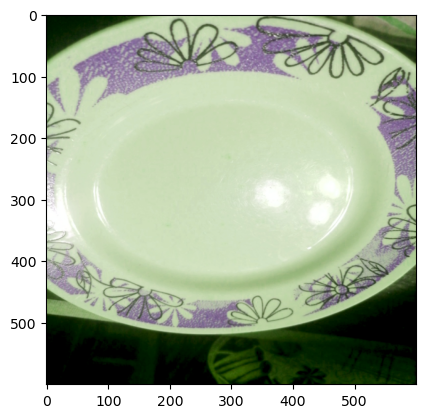

In [12]:
image = plates_aug[366]
plt.imshow(image)

In [13]:
np.asarray(plates_aug).shape

(3396, 600, 600, 3)

In [14]:
len(plates_aug)

3396

In [15]:
df_plate_aug = pd.DataFrame(columns = ['Id', 'label'], dtype = str)
for i in range(len(plates_aug)):
    file_name = 'plate_aug_'+str(i)
    io.imsave(data_dir+'/images/'+file_name+'.jpg', plates_aug[i])
    df_plate_aug.loc[len(df_plate_aug)] = ['plate_aug_'+str(i), 'plate']
    
df_plate_aug

,Id,label
0,plate_aug_0,plate
1,plate_aug_1,plate
2,plate_aug_2,plate
3,plate_aug_3,plate
4,plate_aug_4,plate
...,...,...
3391,plate_aug_3391,plate
3392,plate_aug_3392,plate
3393,plate_aug_3393,plate
3394,plate_aug_3394,plate


In [16]:
df_plate_aug.to_csv(data_dir+'/plate_aug.csv', index = False)

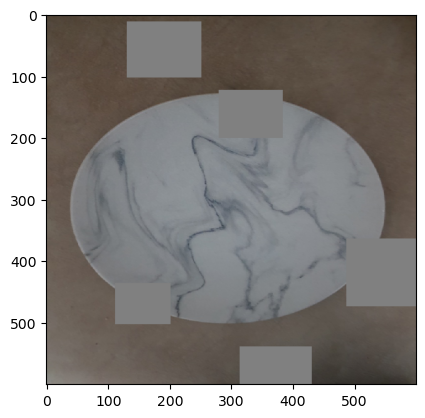

In [17]:
image = plates_aug[2567]
plt.imshow(image)